In [1]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn.objects as so
import os
import io
import re

import random

random.seed(42)
np.random.seed(42)
mpl.rcParams['svg.hashsalt'] = '42'

In [2]:
#GIVEN_NAME = 'eSeMeshA'
GIVEN_NAME = 'eZtunnel'

In [3]:
# set fixed order of elements in graphs
optimization_order = ['disabled', 'enabled']
service_mesh_order = ['none', 'cilium', 'istio-ambient', 'istio-sidecar']

In [4]:
def set_index_order(df):
    df = df.copy()
    df = df.reindex(pd.MultiIndex.from_tuples([ (a, b) for a in service_mesh_order for b in optimization_order], names=['Service Mesh', 'Mode']))
    df.index = pd.MultiIndex.from_tuples([ (a, {'disabled': 'Baseline', 'enabled': GIVEN_NAME}[b]) for (a, b) in df.index.to_numpy()], names=['Service Mesh', 'Mode'])
    return df

In [5]:
def update_legend(g, mapping):
    for text in (g.legend if isinstance(g.legend, mpl.legend.Legend) else g.get_legend()).get_texts():
        text.set(text=mapping[text.get_text()])

In [6]:
def count_decimal_places(num, remove_single_zero=False):
    str_num = str(num)
    if remove_single_zero and str_num.endswith('.0'):
        return 0
    if '.' in str_num:
        return len(str_num) - str_num.index('.') - 1
    else:
        return 0

In [7]:
def float_format(x, remove_single_zero=True):
    return '{:.{}f}'.format(x, min(count_decimal_places(x, remove_single_zero=remove_single_zero), pd.get_option('display.precision')))

In [8]:
def format_data_size(number, from_unit, to_unit, remove_single_decimal_zero=True):
    convert_table = {
        'B': 1,
        'K': 1000,
        'M': 1000 ** 2,
        'G': 1000 ** 3,
        'T': 1000 ** 4,
        'P': 1000 ** 5,
    }
    if from_unit[-1] == 'B' and to_unit[-1] == 'b':
        number *= 8
    if from_unit[-1] == 'b' and to_unit[-1] == 'B':
        number /= 8
    number *= convert_table[from_unit[0].upper()]
    number /= convert_table[to_unit[0].upper()]
    #return float_format(number, remove_single_decimal_zero)
    return number

In [9]:
def format_time(number, from_unit, to_unit, remove_single_decimal_zero=True):
    convert_table = {
        'ns': 1,
        'us': 10 ** 3,
        'ms': 10 ** 6,
         's': 10 ** 9,
    }
    number *= convert_table[from_unit]
    number /= convert_table[to_unit]
    #return float_format(number, remove_single_decimal_zero)
    return number

In [10]:
pd.set_option('display.precision', 1)
#pd.set_option('display.float_format', float_format)
pd.set_option('display.max_columns', None)

In [11]:
def summary_value(df, *, mode='relative', metrics=None, col=None, index=None):
    APPEND_MODES = {
        'relative': lambda series: (series / series.shift() * 100 - 100).map(float_format).map(lambda x: ' ({}%)'.format(x)),
        'absolute': lambda series: (series - series.shift()).map(float_format).map(lambda x: ' ({}{})'.format('-' if x[0] == '-' else '+', x)),
    }

    df = df.copy()
    metric_float = df.astype(float)
    for metric in (df.columns if metrics is None else metrics):
        df[metric] = df[metric].map(float_format)
        df['__append'] = APPEND_MODES[mode](metric_float[metric])
        df['__append'] = df.apply(
            lambda x: \
                x.__append if (x[col] if col else x.name[index]) == 'enabled' \
                else pd.NA,
            1,
        )
        df[metric] = df.apply(lambda x: x[metric] + (x.__append if not pd.isna(x.__append) else ''), 1)
    if '__append' in df.columns:
        del df['__append']
    return df

In [12]:
def print_latex(df):
    df = df.copy()
    df.index = pd.MultiIndex.from_tuples([(f'\\textit{{{a}}}' if a == 'none' else f'\\texttt{{{a}}}', b) for (a, b) in df.index], names=['Service Mesh', 'Mode'])
    df = df.map(lambda value: re.sub(r'\((.*?)\)', lambda match: f'(\\textbf{{{match.group(1)}}})', value.replace('%', '\\%')))
    print(df.to_latex(float_format=float_format))

In [13]:
import os
import re
import zipfile
from pprint import pprint


def logs_processing(basepath='.'):
    files = os.listdir(basepath)
    logs_zip_pattern = re.compile(r'logs_.*\.zip')
    logs_zip_files = [f for f in files if logs_zip_pattern.match(f)]

    workload_log_map = {
        'ping': 'ping-echo',
        'client': 'file-transfer',
        'memtier': 'redis',
    }

    system_logs = []
    workload_logs = {}

    for zip_filename in logs_zip_files:
        zip_filename_components = zip_filename.split('.')[0].split('_')

        if len(zip_filename_components) != 4: continue

        _, cni, service_mesh, optimization = zip_filename_components

        with zipfile.ZipFile(os.path.join(basepath, zip_filename), 'r') as zip_ref:
            for file in zip_ref.infolist():
                if file.is_dir(): continue

                entry = { 'cni': cni, 'service_mesh': service_mesh, 'optimization': optimization, 'workload': None, 'data': None, 'meta': {} }

                filename = file.filename.replace(r'mnt/logs/', '')

                ###################
                ### system logs ###
                ###################

                ### statexec
                if filename.startswith('statexec_metrics'):
                    entry['workload'] = filename.split('_')[2]

                    if entry['workload'] not in workload_log_map.values(): continue

                    data = zip_ref.read(file).decode('utf-8')
                    statexec_pattern = re.compile(r'(?P<metric>.*){(?P<params>.*?)} (?P<value>.+) (?P<timestamp>\d+)')
                    statexec_param_pattern = re.compile(r',?(?P<k>.*?)="(?P<v>.*?)"')
                    data = [statexec_pattern.match(line).groupdict() for line in data.split('\n') if line != '' and line[0] != '#']
                    # TODO: timestamp is in ms. transform to ns
                    #'timestamp': float(value['timestamp']) * (10 ** 6)
                    data = [{**value, 'params': { k: v for (k, v) in statexec_param_pattern.findall(value['params']) if k not in ['instance', 'job', 'role', 'cni', 'optimization', 'service_mesh'] } } for value in data ]
                    entry['data'] = data

                    system_logs.append(entry)
                    continue


                #####################
                ### workload logs ###
                #####################

                entry['workload'] = workload_log_map.get(filename.split('/')[0], None)

                if entry['workload'] == 'ping-echo':
                    data = zip_ref.read(file).decode('utf-8')
                    entry['data'] = data

                elif entry['workload'] == 'file-transfer':
                    data = zip_ref.read(file).decode('utf-8')
                    values = re.findall(r'Ncat: \d+ bytes sent, \d+ bytes received in (\d+.\d+) seconds\.', data)
                    entry['data'] = [float(v) * (10 ** 9) for v in values]

                elif entry['workload'] == 'redis':
                    if filename.endswith('/log.txt'):
                        entry['meta'] = { 'type': 'metrics' }
                        data = zip_ref.read(file).decode('utf-8')
                        data = data.replace(r'Connection error: Connection refused', '')
                        redis_log_pattern = re.compile(r'\[RUN #(?P<iteration>\d+) 100%, *(?P<took>\d+) secs\] *0 threads: *\d+ ops, *\d+ \(avg: *(?P<ops_avg>\d+)\) ops\/sec, *\d+.\d+[KMG]B\/sec \(avg: *(?P<throughput_avg>\d+.\d+[KMG]B)\/sec\), *\d+.\d+ \(avg: *(?P<latency_avg>\d+.\d+)\) msec latency')
                        values = [match.groupdict() for match in redis_log_pattern.finditer(data)]
                        for value in values:
                            # took is in s. transform to ns
                            value['took'] = int(value['took']) * (10 ** 9)

                            # latency_avg is in ms. transform to ns
                            value['latency_avg'] = float(value['latency_avg']) * (10 ** 6)

                            # throughput_avg is in KB, MB, GB. transform to bits
                            # https://github.com/RedisLabs/memtier_benchmark/blob/2.1.2/memtier_benchmark.cpp#L1121
                            B = float(value['throughput_avg'][:-2])
                            # memtier uses 1024 to multiply between units KB, MB, GB. transform to bytes
                            unit = value['throughput_avg'][-2:]
                            if unit == 'GB':
                                B *= 1024 ** 3
                            elif unit == 'MB':
                                B *= 1024 ** 2
                            elif unit == 'KB':
                                B *= 1024
                            # memtier uses bytes. transform to bits
                            B *= 8
                            value['throughput_avg'] = B
                        entry['data'] = values
                    else:
                        match = re.match(r'_FULL_RUN_(?P<iteration>\d+)\.txt$', filename.split('/')[-1])

                        if not match: continue

                        iteration = match.group('iteration')
                        entry['meta'] = { 'type': 'histogram', 'iteration': iteration }
                        data = zip_ref.read(file).decode('utf-8')
                        entry['data'] = '\n'.join([line for line in data.split('\n') if line != '' and line[0] != '#'][:-1])

                ### UNKNOWN
                else:
                    continue

                if entry['workload'] not in workload_logs:
                    workload_logs[entry['workload']] = []

                workload_logs[entry['workload']].append(entry)

    return { 'system_logs': system_logs, 'workload_logs': workload_logs }

In [14]:
logs = logs_processing('../workloads/')

# system-logs

In [15]:
system_logs = pd.DataFrame(logs['system_logs'])
del system_logs['meta']
system_logs = system_logs.explode('data').apply(lambda x: pd.concat([x.drop('data'), pd.json_normalize(x.data, sep='_').iloc[0]]), axis=1)
system_logs = system_logs.astype({'timestamp': 'int64', 'value': 'float64'}).sort_values(by='timestamp', ignore_index=True)
system_logs.drop_duplicates(inplace=True, ignore_index=True)

In [16]:
system_logs.head()

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload
0,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,guest,none,1736354149117,0.0e+00,ping-echo
1,calico,statexec_cpu_seconds_total,disabled,cpu1,NaN,NaN,guestNice,none,1736354149117,0.0e+00,ping-echo
2,calico,statexec_network_sent_bytes_total,disabled,NaN,NaN,calib5d19d16696,NaN,none,1736354149117,1.5e+06,ping-echo
3,calico,statexec_network_received_bytes_total,disabled,NaN,NaN,calib5d19d16696,NaN,none,1736354149117,1.2e+06,ping-echo
4,calico,statexec_network_sent_bytes_total,disabled,NaN,NaN,cali61add15868f,NaN,none,1736354149117,4.6e+05,ping-echo


In [17]:
sorted(system_logs.metric.unique())

['statexec_command_status',
 'statexec_cpu_seconds_total',
 'statexec_disk_read_bytes_total',
 'statexec_disk_write_bytes_total',
 'statexec_memory_available_bytes',
 'statexec_memory_buffers_bytes',
 'statexec_memory_cached_bytes',
 'statexec_memory_free_bytes',
 'statexec_memory_total_bytes',
 'statexec_memory_used_bytes',
 'statexec_memory_used_percent',
 'statexec_metric_collect_duration_ms',
 'statexec_network_received_bytes_total',
 'statexec_network_sent_bytes_total',
 'statexec_statexec_time_since_start_ms',
 'statexec_summary_cpu_cores',
 'statexec_summary_cpu_mean_seconds',
 'statexec_summary_disk_mean_read_bytes_per_second',
 'statexec_summary_disk_mean_write_bytes_per_second',
 'statexec_summary_memory_buffers_bytes',
 'statexec_summary_memory_cached_bytes',
 'statexec_summary_memory_free_bytes',
 'statexec_summary_memory_total_bytes',
 'statexec_summary_memory_used_bytes',
 'statexec_summary_network_mean_received_bytes_per_second',
 'statexec_summary_network_mean_sent_byte

In [18]:
sorted(system_logs[system_logs.metric.eq('statexec_cpu_seconds_total')].params_mode.unique())

['guest',
 'guestNice',
 'idle',
 'iowait',
 'irq',
 'nice',
 'softirq',
 'steal',
 'system',
 'user']

In [19]:
system_logs.timestamp.diff().abs().sort_values(ascending=False)[:25]

221143    670820.0
48701     560888.0
161321    223197.0
247309    206336.0
109809    169805.0
28990     162593.0
198667    114497.0
128389     72959.0
77489      64614.0
85245      61756.0
8774       57659.0
212417     56690.0
35104      53272.0
182901     52617.0
15744      52473.0
260088     51878.0
40701      50751.0
237321     50576.0
230215     50260.0
173231     48196.0
253794     47918.0
135705     47002.0
206037     46529.0
41639       1000.0
223655      1000.0
Name: timestamp, dtype: float64

In [20]:
system_logs['x'] = (system_logs.timestamp.diff().abs().gt(40_000).cumsum() + 1).astype(str)
start_point = system_logs.groupby('x')['timestamp'].transform(lambda x: x.min())
system_logs['elapsed'] = system_logs.timestamp - start_point

In [21]:
cpu_seconds_cum = system_logs[
    (system_logs['metric'] == 'statexec_cpu_seconds_total') &
    (system_logs['params_mode'].isin(['user', 'system']))
].groupby(['workload', 'service_mesh', 'optimization', 'timestamp', 'elapsed'])['value'].sum().reset_index()

cpu_seconds_cum

,workload,service_mesh,optimization,timestamp,elapsed,value
0,file-transfer,cilium,disabled,1736359323695,0,461.0
1,file-transfer,cilium,disabled,1736359323696,1,461.0
2,file-transfer,cilium,disabled,1736359324695,1000,463.1
3,file-transfer,cilium,disabled,1736359325695,2000,463.6
4,file-transfer,cilium,disabled,1736359326695,3000,464.4
...,...,...,...,...,...,...
3032,redis,none,enabled,1736355072865,87000,1871.8
3033,redis,none,enabled,1736355072940,87075,1872.0
3034,redis,none,enabled,1736355073865,88000,1872.4
3035,redis,none,enabled,1736355074865,89000,1873.0


In [22]:
cpu_seconds_usage = cpu_seconds_cum.groupby(['workload', 'service_mesh', 'optimization'])['value'].agg(
    value=lambda x: np.ptp(x),
).reset_index()

cpu_seconds_usage

,workload,service_mesh,optimization,value
0,file-transfer,cilium,disabled,83.4
1,file-transfer,cilium,enabled,82.8
2,file-transfer,istio-ambient,disabled,103.0
3,file-transfer,istio-ambient,enabled,90.1
4,file-transfer,istio-sidecar,disabled,100.7
5,file-transfer,istio-sidecar,enabled,114.5
6,file-transfer,none,disabled,86.4
7,file-transfer,none,enabled,81.4
8,ping-echo,cilium,disabled,104.9
9,ping-echo,cilium,enabled,92.3


In [23]:
memory_used_bytes = system_logs[system_logs.metric.eq('statexec_memory_used_bytes')]
memory_used_bytes

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload,x,elapsed
58,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354149117,1.3e+09,ping-echo,1,0
123,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354149120,1.3e+09,ping-echo,1,3
219,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354150117,1.4e+09,ping-echo,1,1000
254,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354151117,1.3e+09,ping-echo,1,2000
344,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354152117,1.3e+09,ping-echo,1,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267990,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736360087403,1.4e+09,redis,24,86000
268046,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736360087689,1.3e+09,redis,24,86286
268154,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736360088403,1.3e+09,redis,24,87000
268247,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736360089403,1.3e+09,redis,24,88000


# file-transfer

In [24]:
file_transfer = pd.DataFrame(logs['workload_logs']['file-transfer'])
del file_transfer['meta']
file_transfer.rename(columns={'data': 'took'}, inplace=True)
file_transfer = file_transfer.explode('took', ignore_index=True).astype({'took': 'int64'})

In [25]:
file_transfer.head()

,cni,service_mesh,optimization,workload,took
0,calico,istio-ambient,disabled,file-transfer,10660000000
1,calico,istio-ambient,disabled,file-transfer,10860000000
2,calico,istio-ambient,disabled,file-transfer,10590000000
3,calico,istio-ambient,disabled,file-transfer,10350000000
4,calico,istio-ambient,disabled,file-transfer,10440000000


In [26]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('file-transfer')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))
summary = summary_value(summary, mode='absolute', index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25             p50             avg  \
Service Mesh  Mode                                                       
none          Baseline          1354.9          1368.1          1368.0   
              eZtunnel  1381.6 (+26.7)  1392.9 (+24.8)  1392.0 (+24.1)   
cilium        Baseline          1283.2          1291.1          1292.7   
              eZtunnel  1327.3 (+44.1)  1332.5 (+41.4)  1332.5 (+39.8)   
istio-ambient Baseline          1632.2          1647.5          1644.8   
              eZtunnel  1650.8 (+18.5)  1659.0 (+11.6)  1660.2 (+15.4)   
istio-sidecar Baseline          1614.2          1626.5          1625.4   
              eZtunnel  1648.9 (+34.6)  1660.2 (+33.7)  1668.6 (+43.2)   

                                   p75  
Service Mesh  Mode                      
none          Baseline          1379.7  
              eZtunnel  1401.6 (+21.9)  
cilium        Baseline          1302.4  
              eZtunnel  1337.0 (+34.6)  
istio-ambient Baseline          1656.8  
              eZtunnel  1669.3 (+12.5)  
istio-sidecar Baseline          1637.5  
              eZtunnel  1689.6 (+52.2)

In [27]:
memory_used_bytes[memory_used_bytes.workload.eq('file-transfer')]

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload,x,elapsed
8837,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354305776,1.3e+09,file-transfer,2,0
8930,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354305780,1.3e+09,file-transfer,2,4
8979,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354306776,1.4e+09,file-transfer,2,1000
9088,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354307776,1.4e+09,file-transfer,2,2000
9151,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354308776,1.4e+09,file-transfer,2,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259658,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736359946525,1.3e+09,file-transfer,23,64000
259784,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736359947148,1.3e+09,file-transfer,23,64623
259838,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736359947525,1.3e+09,file-transfer,23,65000
259990,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736359948525,1.3e+09,file-transfer,23,66000


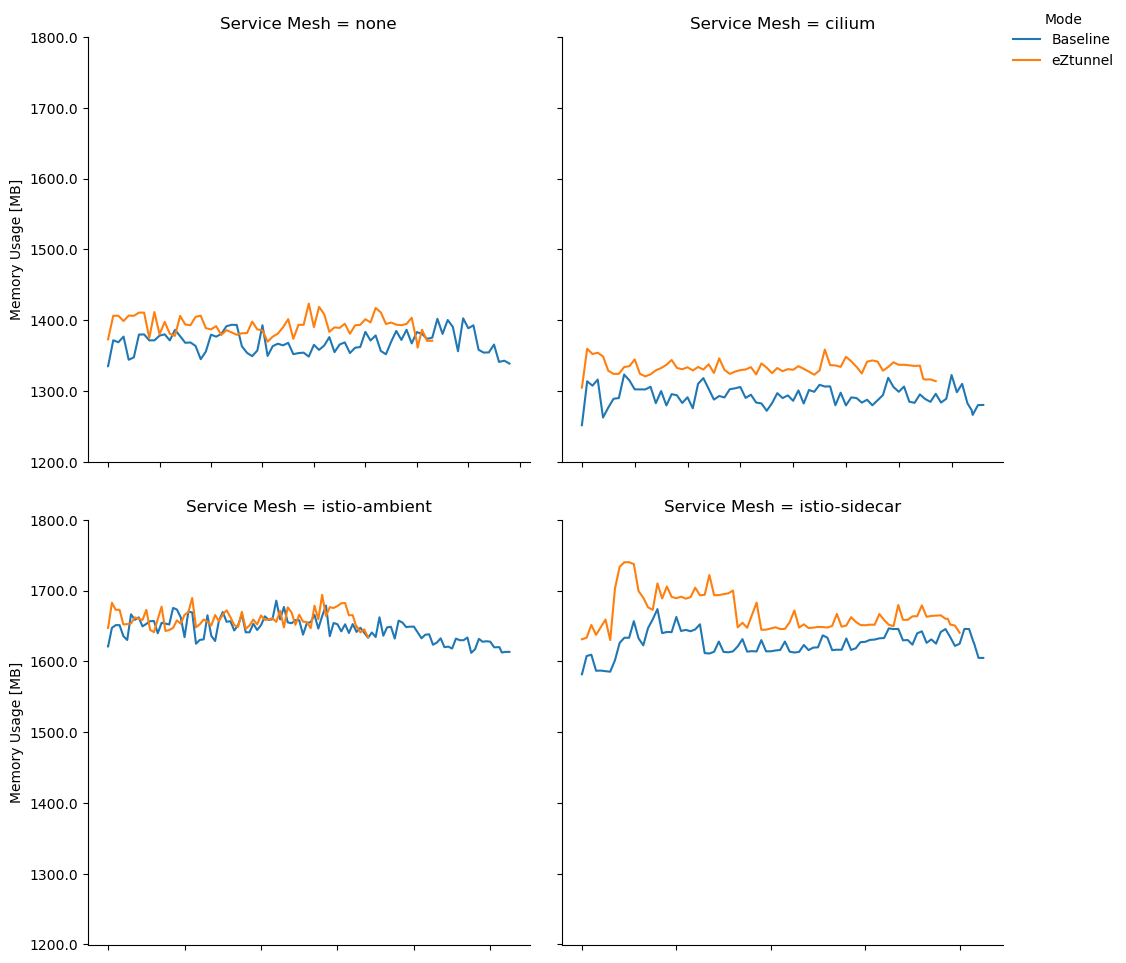

In [28]:
g = sns.relplot(kind='line', data=memory_used_bytes[memory_used_bytes.workload.eq('file-transfer')], y='value', x='elapsed', hue='optimization', col='service_mesh', col_order=service_mesh_order, col_wrap=2, facet_kws={'sharey': True, 'sharex': False})

for ax in g.axes:
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set(
        title=ax.get_title().replace('service_mesh', 'Service Mesh'),
        xlabel='',
        ylabel='Memory Usage [MB]',
        yticklabels=[format_data_size(tick, 'B', 'MB') for tick in ax.get_yticks()],
        xticklabels=[],
    )

g.legend.set(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})
#g.get_legend().set_visible(False)
g.figure.savefig('graphs/file-transfer-relplot-line-memory-usage.svg', bbox_inches='tight', metadata={'Date': None})

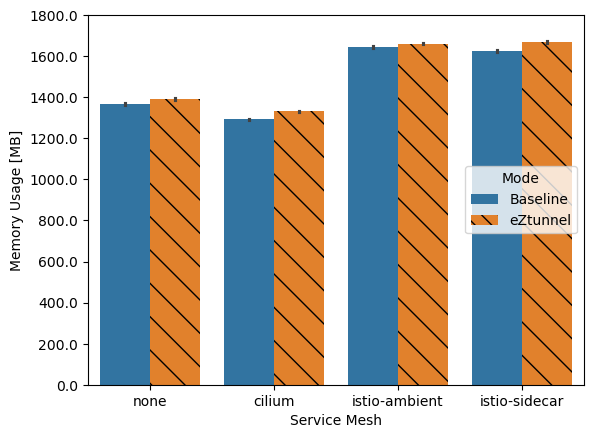

In [29]:
g = sns.barplot(data=memory_used_bytes[memory_used_bytes.workload.eq('file-transfer')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Memory Usage [MB]',
    yticklabels=[format_data_size(tick, 'B', 'MB') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='center right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/file-transfer-barplot-memory-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [30]:
summary = cpu_seconds_usage[cpu_seconds_usage.workload.eq('file-transfer')].groupby(['service_mesh', 'optimization'])[['value']].first()
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

value
Service Mesh  Mode                   
none          Baseline           86.4
              eZtunnel   81.4 (-5.8%)
cilium        Baseline           83.4
              eZtunnel   82.8 (-0.7%)
istio-ambient Baseline          103.0
              eZtunnel  90.1 (-12.5%)
istio-sidecar Baseline          100.7
              eZtunnel  114.5 (13.7%)

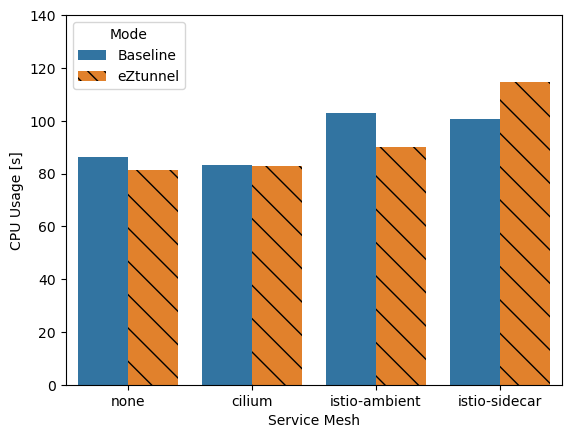

In [31]:
g = sns.barplot(data=cpu_seconds_usage[cpu_seconds_usage.workload.eq('file-transfer')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='CPU Usage [s]',
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/file-transfer-barplot-cpu-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [32]:
summary = file_transfer.groupby(['service_mesh', 'optimization'])['took'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 's'))
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25           p50           avg           p75
Service Mesh  Mode                                                            
none          Baseline          10.5          10.5          10.6          10.7
              eZtunnel  8.3 (-21.2%)  8.3 (-21.0%)  8.4 (-21.0%)  8.4 (-21.1%)
cilium        Baseline           9.3           9.5           9.5           9.6
              eZtunnel  8.3 (-10.8%)  8.4 (-11.7%)  8.4 (-11.3%)  8.4 (-12.2%)
istio-ambient Baseline          10.4          10.6          10.6          10.7
              eZtunnel  8.4 (-19.3%)  8.5 (-20.1%)  8.4 (-20.2%)  8.5 (-20.4%)
istio-sidecar Baseline           6.8           6.9           6.9           6.9
              eZtunnel   8.2 (20.8%)   8.3 (20.0%)   8.4 (21.2%)   8.5 (23.5%)

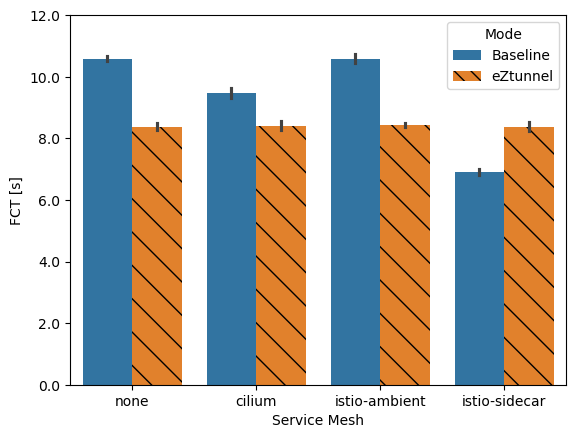

In [33]:
g = sns.barplot(data=file_transfer, y='took', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='FCT [s]',
    yticklabels=[format_time(tick, 'ns', 's') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/file-transfer-barplot-fct.svg', bbox_inches='tight', metadata={'Date': None})

# ping-echo

In [34]:
ping_echo = pd.DataFrame(logs['workload_logs']['ping-echo'])
del ping_echo['meta']
ping_echo = ping_echo.apply(lambda x: x.drop('data').to_frame().T.join(pd.read_csv(io.StringIO(x.data)), how='cross'), axis=1)
ping_echo = pd.concat(ping_echo.tolist(), ignore_index=True)
ping_echo['latency'] = ping_echo['end'] - ping_echo['start']
ping_echo['throughput'] = (24 * 1e9) / ping_echo['latency']
ping_echo['RPS'] = 1e9 / ping_echo['latency']

In [35]:
ping_echo.head()

,cni,service_mesh,optimization,workload,run,start,end,latency,throughput,RPS
0,calico,istio-ambient,disabled,ping-echo,0,1736357548673463663,1736357548673984875,521212,46046.5,1918.6
1,calico,istio-ambient,disabled,ping-echo,0,1736357548674001489,1736357548674170968,169479,141610.5,5900.4
2,calico,istio-ambient,disabled,ping-echo,0,1736357548674179030,1736357548674310892,131862,182008.5,7583.7
3,calico,istio-ambient,disabled,ping-echo,0,1736357548674326890,1736357548674448536,121646,197293.8,8220.6
4,calico,istio-ambient,disabled,ping-echo,0,1736357548674453871,1736357548674564736,110865,216479.5,9020.0


In [36]:
grouped = ping_echo.groupby(['cni', 'service_mesh', 'optimization', 'workload', 'run'])
ping_echo_extra = grouped.agg(start_min=('start', 'min'), end_max=('end', 'max'))
ping_echo_extra['fct'] = ping_echo_extra['end_max'] - ping_echo_extra['start_min']
ping_echo_extra['jitter'] = grouped[['latency']].std(ddof=0)
ping_echo_extra.reset_index(inplace=True)

In [37]:
ping_echo_extra.head()

,cni,service_mesh,optimization,workload,run,start_min,end_max,fct,jitter
0,calico,istio-ambient,disabled,ping-echo,0,1736357548673463663,1736357563293586211,14620122548,108852.8
1,calico,istio-ambient,disabled,ping-echo,1,1736357565295443961,1736357580060699877,14765255916,99831.8
2,calico,istio-ambient,disabled,ping-echo,2,1736357582062233676,1736357596750912885,14688679209,93902.5
3,calico,istio-ambient,disabled,ping-echo,3,1736357598752148818,1736357613694342945,14942194127,102313.2
4,calico,istio-ambient,disabled,ping-echo,4,1736357615696592734,1736357630437159373,14740566639,103280.0


In [38]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))
summary = summary_value(summary, mode='absolute', index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25             p50             avg  \
Service Mesh  Mode                                                       
none          Baseline          1373.6          1382.6          1380.2   
              eZtunnel  1404.5 (+30.9)  1414.5 (+31.8)  1411.4 (+31.2)   
cilium        Baseline          1316.8          1325.1          1325.7   
              eZtunnel  1345.5 (+28.7)  1350.9 (+25.8)  1352.4 (+26.7)   
istio-ambient Baseline          1652.2          1662.5          1660.7   
              eZtunnel  1670.0 (+17.8)  1679.3 (+16.8)  1677.7 (+17.0)   
istio-sidecar Baseline          1636.2          1650.7          1645.7   
              eZtunnel  1663.0 (+26.7)  1670.7 (+20.0)  1667.6 (+21.8)   

                                   p75  
Service Mesh  Mode                      
none          Baseline          1387.6  
              eZtunnel  1422.1 (+34.5)  
cilium        Baseline          1334.6  
              eZtunnel  1360.6 (+26.0)  
istio-ambient Baseline          1673.6  
              eZtunnel  1689.7 (+16.1)  
istio-sidecar Baseline          1661.6  
              eZtunnel  1678.0 (+16.4)

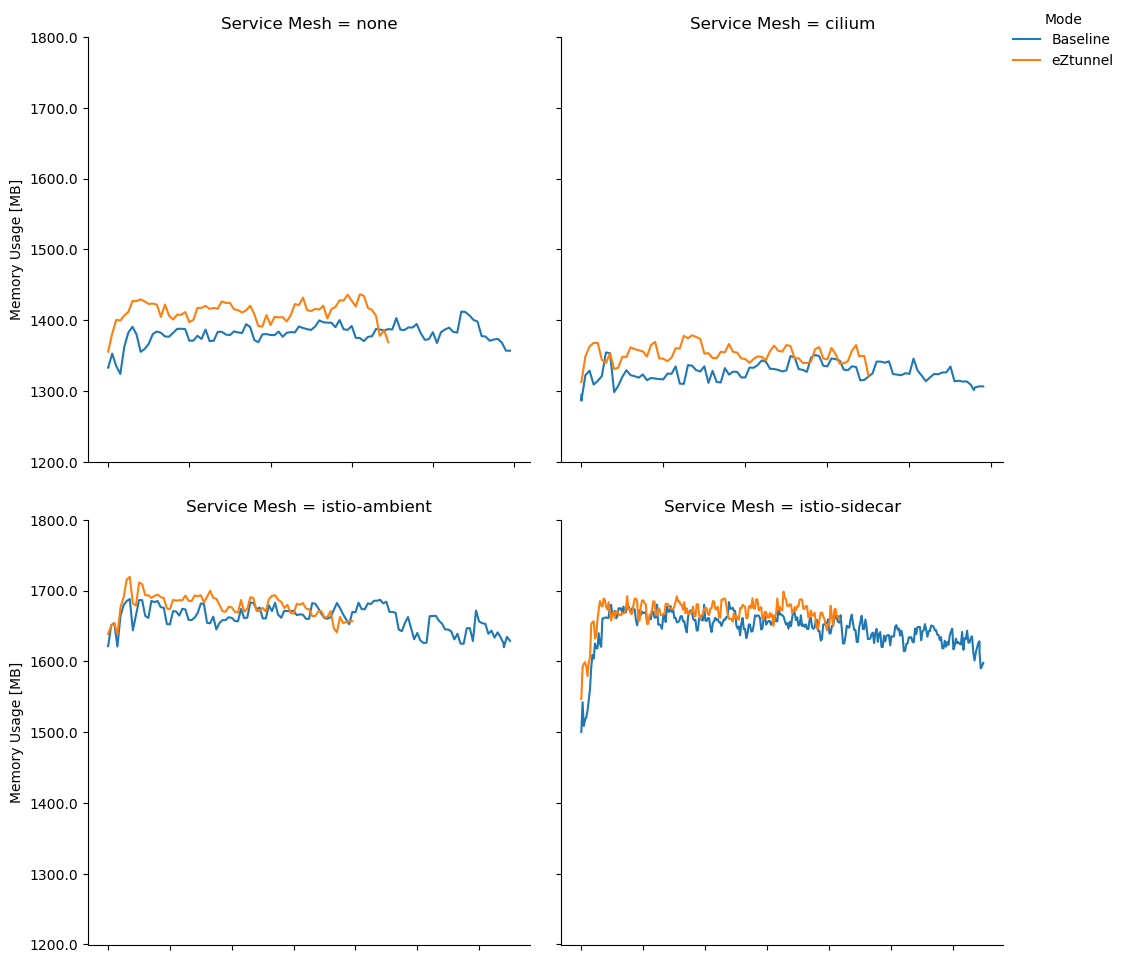

In [39]:
g = sns.relplot(kind='line', data=memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')], y='value', x='elapsed', hue='optimization', col='service_mesh', col_order=service_mesh_order, col_wrap=2, facet_kws={'sharey': True, 'sharex': False})

for ax in g.axes:
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set(
        title=ax.get_title().replace('service_mesh', 'Service Mesh'),
        xlabel='',
        ylabel='Memory Usage [MB]',
        yticklabels=[format_data_size(tick, 'B', 'MB') for tick in ax.get_yticks()],
        xticklabels=[],
    )

g.legend.set(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})
#g.get_legend().set_visible(False)
g.figure.savefig('graphs/ping-echo-relplot-line-memory-usage.svg', bbox_inches='tight', metadata={'Date': None})

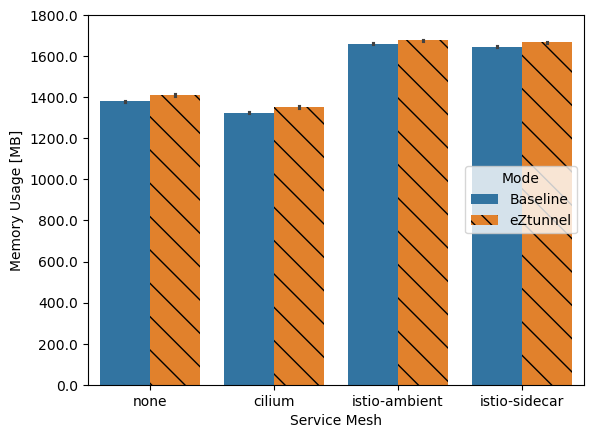

In [40]:
g = sns.barplot(data=memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Memory Usage [MB]',
    yticklabels=[format_data_size(tick, 'B', 'MB') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='center right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/ping-echo-barplot-memory-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [41]:
summary = cpu_seconds_usage[cpu_seconds_usage.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])[['value']].first()
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

value
Service Mesh  Mode                    
none          Baseline           110.5
              eZtunnel   92.6 (-16.2%)
cilium        Baseline           104.9
              eZtunnel   92.3 (-12.1%)
istio-ambient Baseline           132.2
              eZtunnel  103.2 (-21.9%)
istio-sidecar Baseline           357.8
              eZtunnel  274.7 (-23.2%)

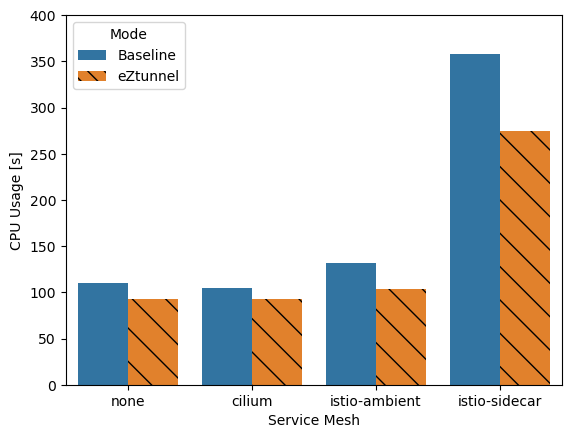

In [42]:
g = sns.barplot(data=cpu_seconds_usage[cpu_seconds_usage.workload.eq('ping-echo')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='CPU Usage [s]',
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/ping-echo-barplot-cpu-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [43]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['RPS'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
)
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25              p50              avg  \
Service Mesh  Mode                                                          
none          Baseline           6338.0           8238.7           8186.1   
              eZtunnel  10260.2 (61.9%)  13600.8 (65.1%)  13104.6 (60.1%)   
cilium        Baseline           7447.3           9803.7           9685.2   
              eZtunnel  10275.5 (38.0%)  13541.5 (38.1%)  13058.0 (34.8%)   
istio-ambient Baseline           6303.4           8196.4           8172.3   
              eZtunnel  10385.2 (64.8%)  13808.1 (68.5%)  13274.4 (62.4%)   
istio-sidecar Baseline           1625.3           2017.9           2049.1   
              eZtunnel   2781.4 (71.1%)   3479.5 (72.4%)   3502.1 (70.9%)   

                                    p75  
Service Mesh  Mode                       
none          Baseline          10240.6  
              eZtunnel  16514.2 (61.3%)  
cilium        Baseline          12055.0  
              eZtunnel  16422.5 (36.2%)  
istio-ambient Baseline          10124.0  
              eZtunnel  16728.0 (65.2%)  
istio-sidecar Baseline           2459.8  
              eZtunnel   4235.2 (72.2%)

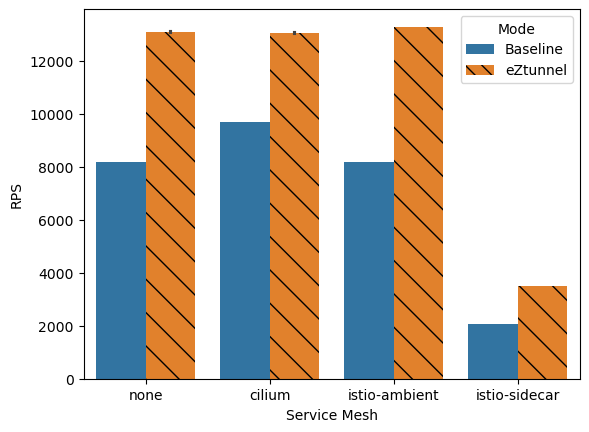

In [44]:
g = sns.barplot(data=ping_echo, y='RPS', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set(
    xlabel='Service Mesh',
    ylabel='RPS',
)

g.legend(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/ping-echo-barplot-rps.svg', bbox_inches='tight', metadata={'Date': None})

In [45]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['throughput'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'b', 'KB'))
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25           p50           avg           p75
Service Mesh  Mode                                                            
none          Baseline          19.0          24.7          24.6          30.7
              eZtunnel  30.8 (61.9%)  40.8 (65.1%)  39.3 (60.1%)  49.5 (61.3%)
cilium        Baseline          22.3          29.4          29.1          36.2
              eZtunnel  30.8 (38.0%)  40.6 (38.1%)  39.2 (34.8%)  49.3 (36.2%)
istio-ambient Baseline          18.9          24.6          24.5          30.4
              eZtunnel  31.2 (64.8%)  41.4 (68.5%)  39.8 (62.4%)  50.2 (65.2%)
istio-sidecar Baseline           4.9           6.1           6.1           7.4
              eZtunnel   8.3 (71.1%)  10.4 (72.4%)  10.5 (70.9%)  12.7 (72.2%)

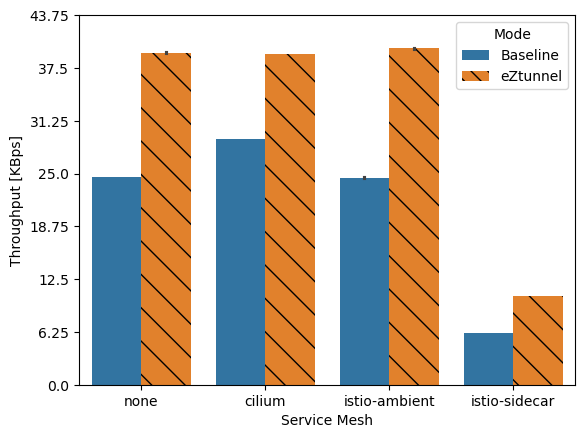

In [46]:
g = sns.barplot(data=ping_echo, y='throughput', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Throughput [KBps]',
    yticklabels=[format_data_size(tick, 'b', 'KB') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/ping-echo-barplot-throughput.svg', bbox_inches='tight', metadata={'Date': None})

In [47]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'us'))
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25             p50             avg  \
Service Mesh  Mode                                                       
none          Baseline            97.7           121.4           139.8   
              eZtunnel   60.6 (-38.0%)   73.5 (-39.4%)   91.2 (-34.8%)   
cilium        Baseline            83.0           102.0           118.5   
              eZtunnel   60.9 (-26.6%)   73.8 (-27.6%)   91.4 (-22.9%)   
istio-ambient Baseline            98.8           122.0           140.5   
              eZtunnel   59.8 (-39.5%)   72.4 (-40.6%)   91.1 (-35.2%)   
istio-sidecar Baseline           406.5           495.6           551.5   
              eZtunnel  236.1 (-41.9%)  287.4 (-42.0%)  320.4 (-41.9%)   

                                   p75  
Service Mesh  Mode                      
none          Baseline           157.8  
              eZtunnel   97.5 (-38.2%)  
cilium        Baseline           134.3  
              eZtunnel   97.3 (-27.5%)  
istio-ambient Baseline           158.6  
              eZtunnel   96.3 (-39.3%)  
istio-sidecar Baseline           615.3  
              eZtunnel  359.5 (-41.6%)

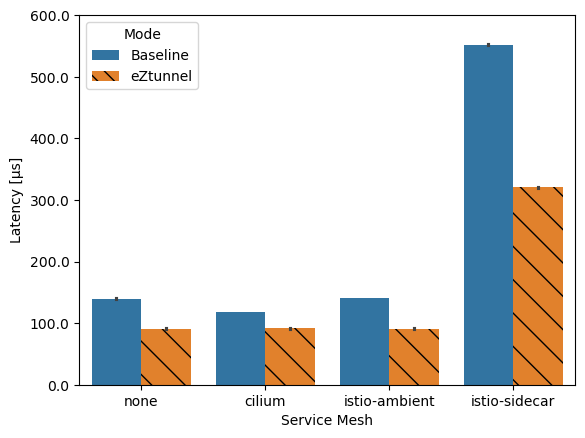

In [48]:
g = sns.barplot(data=ping_echo, y='latency', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Latency [µs]',
    yticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/ping-echo-barplot-latency.svg', bbox_inches='tight', metadata={'Date': None})

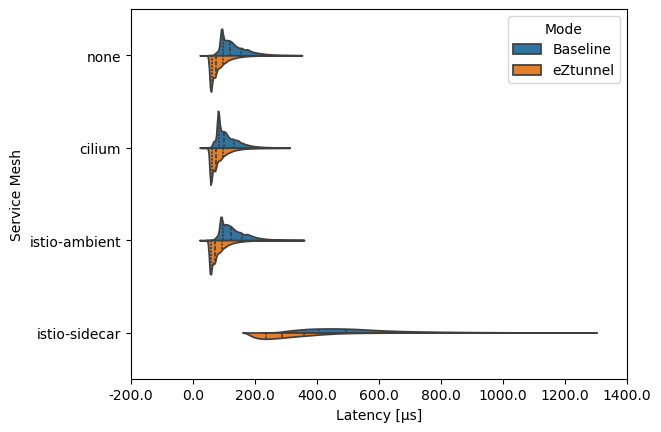

In [49]:
p99 = ping_echo.groupby('service_mesh').latency.transform(lambda x: x.quantile(0.99))

g = sns.violinplot(data=ping_echo[ping_echo.latency.lt(p99)], x='latency', y='service_mesh', hue='optimization', split=True, inner='quart', cut=0, order=service_mesh_order, hue_order=optimization_order)

g.set_xticks(g.get_xticks().tolist())
g.set(
    #title='',
    ylabel='Service Mesh',
    xlabel='Latency [µs]',
    xticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_xticks()],
)

g.legend(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

g.figure.savefig('graphs/ping-echo-violinplot-latency-p99.svg', bbox_inches='tight', metadata={'Date': None})

In [50]:
summary = ping_echo_extra.groupby(['service_mesh', 'optimization'])['jitter'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'us'))
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25             p50             avg  \
Service Mesh  Mode                                                       
none          Baseline            95.2            96.0            96.1   
              eZtunnel    92.3 (-3.1%)    95.8 (-0.2%)    94.7 (-1.4%)   
cilium        Baseline            87.6            87.9            87.9   
              eZtunnel     96.0 (9.6%)    97.4 (10.8%)   101.3 (15.2%)   
istio-ambient Baseline            99.8           102.3           101.6   
              eZtunnel    94.7 (-5.1%)    103.9 (1.5%)    110.9 (9.1%)   
istio-sidecar Baseline           276.7           278.3           278.5   
              eZtunnel  171.8 (-37.9%)  179.1 (-35.6%)  178.8 (-35.8%)   

                                   p75  
Service Mesh  Mode                      
none          Baseline            96.6  
              eZtunnel     97.3 (0.7%)  
cilium        Baseline            89.2  
              eZtunnel    99.4 (11.5%)  
istio-ambient Baseline           103.3  
              eZtunnel    104.5 (1.1%)  
istio-sidecar Baseline           279.3  
              eZtunnel  180.0 (-35.6%)

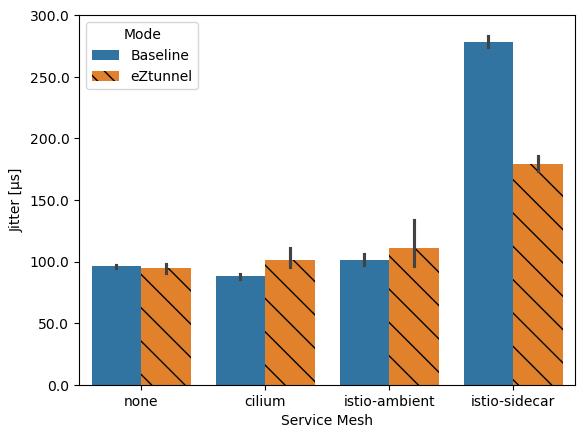

In [51]:
g = sns.barplot(data=ping_echo_extra, y='jitter', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Jitter [µs]',
    yticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/ping-echo-barplot-jitter.svg', bbox_inches='tight', metadata={'Date': None})

In [52]:
summary = ping_echo_extra.groupby(['service_mesh', 'optimization'])['fct'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 's'))
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25            p50            avg  \
Service Mesh  Mode                                                    
none          Baseline           14.5           14.8           14.6   
              eZtunnel   9.5 (-34.2%)   9.7 (-34.7%)   9.6 (-34.4%)   
cilium        Baseline           12.3           12.4           12.5   
              eZtunnel   9.6 (-22.0%)   9.6 (-22.7%)   9.6 (-22.7%)   
istio-ambient Baseline           14.7           14.7           14.8   
              eZtunnel   9.5 (-35.1%)   9.6 (-34.9%)   9.6 (-34.9%)   
istio-sidecar Baseline           55.2           56.1           56.3   
              eZtunnel  32.8 (-40.7%)  33.0 (-41.2%)  32.9 (-41.5%)   

                                  p75  
Service Mesh  Mode                     
none          Baseline           14.8  
              eZtunnel   9.7 (-34.7%)  
cilium        Baseline           12.6  
              eZtunnel   9.7 (-23.6%)  
istio-ambient Baseline           14.8  
              eZtunnel   9.6 (-34.7%)  
istio-sidecar Baseline           57.8  
              eZtunnel  33.1 (-42.9%)

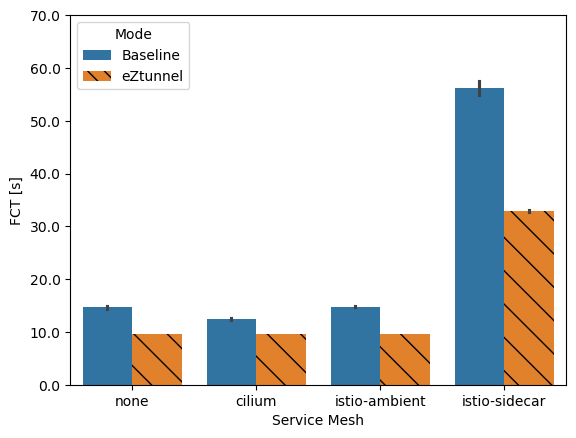

In [53]:
g = sns.barplot(data=ping_echo_extra, y='fct', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='FCT [s]',
    yticklabels=[format_time(tick, 'ns', 's') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/ping-echo-barplot-fct.svg', bbox_inches='tight', metadata={'Date': None})

In [54]:
summary_latency = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    #std=lambda x: x.std(ddof=0),
).map(lambda x: format_time(x, 'ns', 'us'))

summary_jitter = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    #avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
).map(lambda x: format_time(x, 'ns', 'us'))

summary_rps = ping_echo.groupby(['service_mesh', 'optimization'])['RPS'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
)

summary_fct = ping_echo_extra.groupby(['service_mesh', 'optimization'])['fct'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
).map(lambda x: format_time(x, 'ns', 's'))

summary_cpu = cpu_seconds_usage[cpu_seconds_usage.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    total=lambda x: x.iloc[0],
    #p75=lambda x: x.quantile(.75),
    #std=lambda x: x.std(ddof=0),
)

summary_memory = memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
).map(lambda x: format_data_size(x, 'B', 'MB'))

summary = pd.DataFrame({
    'Latency (µs)': summary_value(summary_latency, index=1)['avg'],
    'Jitter (µs)': summary_value(summary_jitter, index=1)['std'],
    'RPS': summary_value(summary_rps, index=1)['avg'],
    'FCT (s)': summary_value(summary_fct, index=1)['avg'],
    'CPU (s)': summary_value(summary_cpu, index=1)['total'],
    'Memory (MB)': summary_value(summary_memory, index=1)['avg'],
})
summary = set_index_order(summary)

summary
#print_latex(summary)

Latency (µs)     Jitter (µs)              RPS  \
Service Mesh  Mode                                                        
none          Baseline           139.8            96.1           8186.1   
              eZtunnel   91.2 (-34.8%)    94.8 (-1.4%)  13104.6 (60.1%)   
cilium        Baseline           118.5            88.0           9685.2   
              eZtunnel   91.4 (-22.9%)   101.7 (15.6%)  13058.0 (34.8%)   
istio-ambient Baseline           140.5           101.8           8172.3   
              eZtunnel   91.1 (-35.2%)   113.4 (11.4%)  13274.4 (62.4%)   
istio-sidecar Baseline           551.5           278.9           2049.1   
              eZtunnel  320.4 (-41.9%)  179.0 (-35.8%)   3502.1 (70.9%)   

                              FCT (s)         CPU (s)    Memory (MB)  
Service Mesh  Mode                                                    
none          Baseline           14.6           110.5         1380.2  
              eZtunnel   9.6 (-34.4%)   92.6 (-16.2%)  1411.4 (2.3%)  
cilium        Baseline           12.5           104.9         1325.7  
              eZtunnel   9.6 (-22.7%)   92.3 (-12.1%)  1352.4 (2.0%)  
istio-ambient Baseline           14.8           132.2         1660.7  
              eZtunnel   9.6 (-34.9%)  103.2 (-21.9%)  1677.7 (1.0%)  
istio-sidecar Baseline           56.3           357.8         1645.7  
              eZtunnel  32.9 (-41.5%)  274.7 (-23.2%)  1667.6 (1.3%)

# redis

In [55]:
redis_raw = pd.DataFrame(logs['workload_logs']['redis'])
redis_raw = redis_raw.apply(lambda x: pd.concat([x.drop('meta'), pd.json_normalize(x.meta).iloc[0]]), axis=1)

In [56]:
redis = redis_raw[redis_raw.type.eq('metrics')].drop(['iteration', 'type'], axis=1).explode('data', ignore_index=True)
redis = redis.apply(lambda x: pd.concat([x.drop('data'), pd.Series({} if pd.isna(x.data) else x.data)]), axis=1)
redis['took'] = redis.took.apply(lambda x: pd.NA if pd.isna(x) else int(x))
redis = redis.map(lambda x: pd.NA if pd.isna(x) else x) \
    .astype({'took': 'Int64', 'latency_avg': 'Float64', 'ops_avg': 'Float64', 'throughput_avg': 'Float64'})

In [57]:
redis.head()

,cni,optimization,service_mesh,workload,iteration,took,ops_avg,throughput_avg,latency_avg
0,calico,disabled,istio-ambient,redis,1,19000000000,50057.0,17364418.6,1990000.0
1,calico,disabled,istio-ambient,redis,2,20000000000,48279.0,16777216.0,2070000.0
2,calico,disabled,istio-ambient,redis,3,20000000000,48255.0,16777216.0,2070000.0
3,calico,disabled,istio-ambient,redis,4,20000000000,48781.0,16944988.2,2050000.0
4,calico,disabled,istio-ambient,redis,5,20000000000,48314.0,16777216.0,2070000.0


In [58]:
hgrm_quantile = lambda df, q: df[df.percentile.ge(q)].iloc[0]

In [59]:
redis_hist = redis_raw[redis_raw.type.eq('histogram')].drop('type', axis=1)
def redis_hist_transform(x):
    ret = pd.read_csv(io.StringIO(x.data), sep=' +', engine='python').drop(columns='1/(1-Percentile)').rename(columns={'Value': 'latency', 'Percentile': 'percentile', 'TotalCount': 'total_count'})
    ret = x.drop('data').to_frame().T.join(ret, how='cross')
    ret['total_count_diff'] = ret.total_count - ret.total_count.shift(1, fill_value=0)
    return ret
redis_hist = redis_hist.apply(redis_hist_transform, axis=1)
redis_hist = pd.concat(redis_hist.tolist(), ignore_index=True)

In [60]:
redis_hist.head()

,cni,iteration,optimization,service_mesh,workload,latency,percentile,total_count,total_count_diff
0,calico,3,disabled,istio-ambient,redis,4.7e-02,0.0e+00,2,2
1,calico,3,disabled,istio-ambient,redis,1.2e+00,5.0e-02,51144,51142
2,calico,3,disabled,istio-ambient,redis,1.4e+00,1.0e-01,100043,48899
3,calico,3,disabled,istio-ambient,redis,1.4e+00,1.5e-01,150213,50170
4,calico,3,disabled,istio-ambient,redis,1.5e+00,2.0e-01,205650,55437


In [61]:
hgrm_quantile(redis_hist, .5)

cni                        calico
iteration                       3
optimization             disabled
service_mesh        istio-ambient
workload                    redis
latency                       1.7
percentile                    0.5
total_count                503018
total_count_diff            45321
Name: 10, dtype: object

In [62]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('redis')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))
summary = summary_value(summary, mode='absolute', index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25             p50             avg  \
Service Mesh  Mode                                                        
none          Baseline           1393.1          1464.2          1442.0   
              eZtunnel   1466.1 (+73.0)  1525.5 (+61.3)  1503.4 (+61.4)   
cilium        Baseline           1333.3          1428.9          1392.9   
              eZtunnel   1414.9 (+81.6)  1477.6 (+48.6)  1452.4 (+59.5)   
istio-ambient Baseline           1637.8          1742.0          1705.2   
              eZtunnel  1738.9 (+101.1)  1802.5 (+60.5)  1773.6 (+68.5)   
istio-sidecar Baseline           1765.3          1788.3          1769.7   
              eZtunnel   1813.4 (+48.1)  1836.1 (+47.7)  1816.5 (+46.8)   

                                   p75  
Service Mesh  Mode                      
none          Baseline          1479.4  
              eZtunnel  1537.9 (+58.5)  
cilium        Baseline          1434.9  
              eZtunnel  1485.8 (+50.9)  
istio-ambient Baseline          1759.7  
              eZtunnel  1813.3 (+53.6)  
istio-sidecar Baseline          1813.9  
              eZtunnel  1860.8 (+46.9)

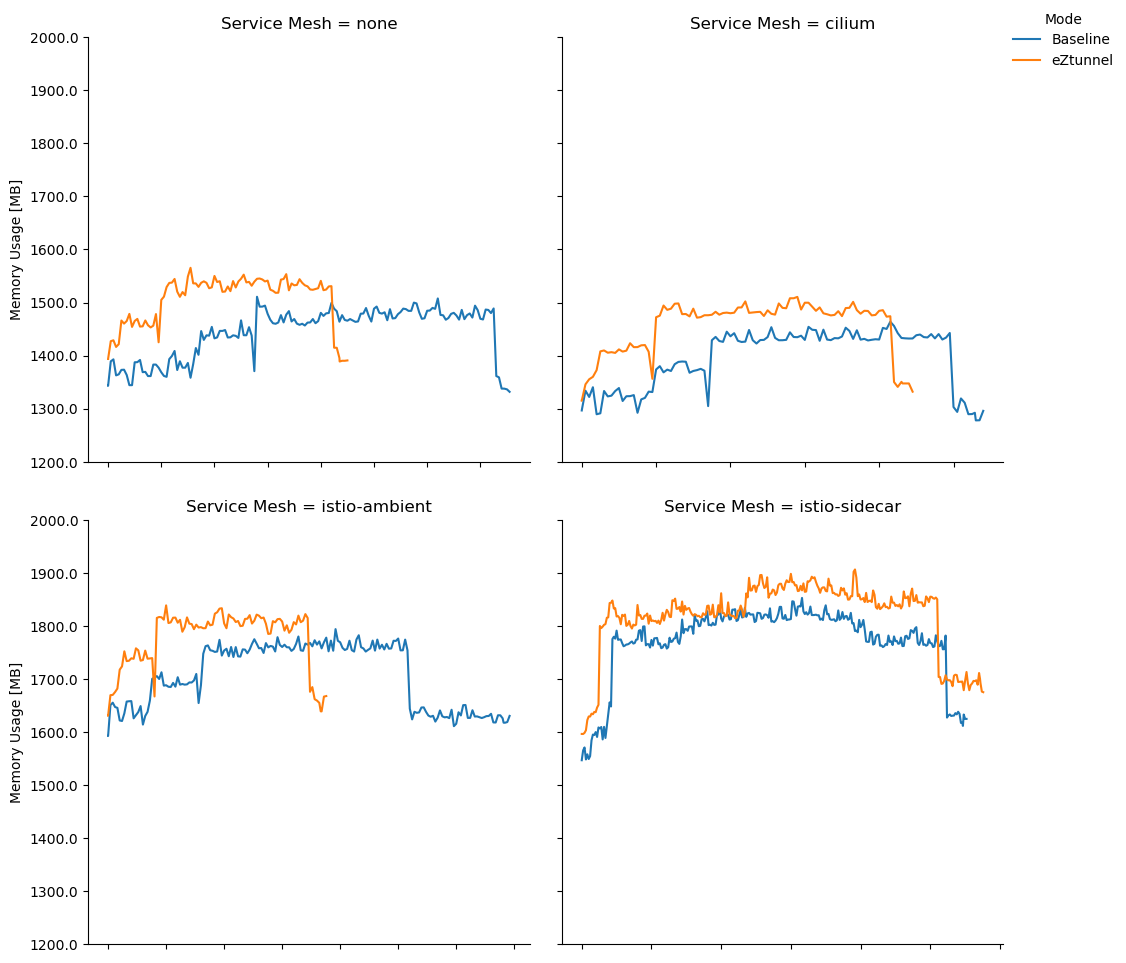

In [63]:
g = sns.relplot(kind='line', data=memory_used_bytes[memory_used_bytes.workload.eq('redis')], y='value', x='elapsed', hue='optimization', col='service_mesh', col_order=service_mesh_order, col_wrap=2, facet_kws={'sharey': True, 'sharex': False})

for ax in g.axes:
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set(
        title=ax.get_title().replace('service_mesh', 'Service Mesh'),
        xlabel='',
        ylabel='Memory Usage [MB]',
        yticklabels=[format_data_size(tick, 'B', 'MB') for tick in ax.get_yticks()],
        xticklabels=[],
    )

g.legend.set(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})
#g.get_legend().set_visible(False)
g.figure.savefig('graphs/redis-relplot-line-memory-usage.svg', bbox_inches='tight', metadata={'Date': None})

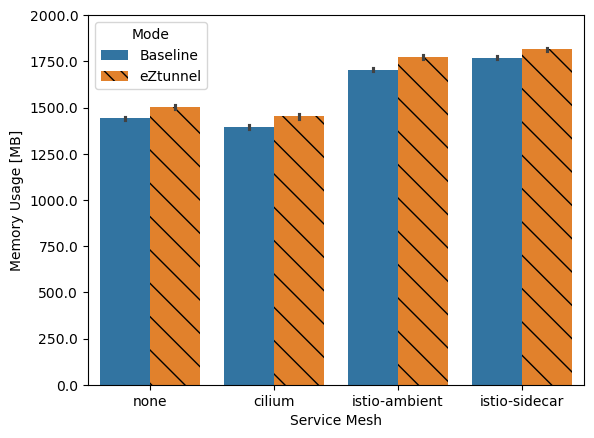

In [64]:
g = sns.barplot(data=memory_used_bytes[memory_used_bytes.workload.eq('redis')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Memory Usage [MB]',
    yticklabels=[format_data_size(tick, 'B', 'MB') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/redis-barplot-memory-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [65]:
summary = cpu_seconds_usage[cpu_seconds_usage.workload.eq('redis')].groupby(['service_mesh', 'optimization'])[['value']].first()
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

value
Service Mesh  Mode                   
none          Baseline          204.4
              eZtunnel   220.9 (8.1%)
cilium        Baseline          167.9
              eZtunnel  216.9 (29.2%)
istio-ambient Baseline          219.7
              eZtunnel   226.4 (3.0%)
istio-sidecar Baseline          586.4
              eZtunnel  713.9 (21.7%)

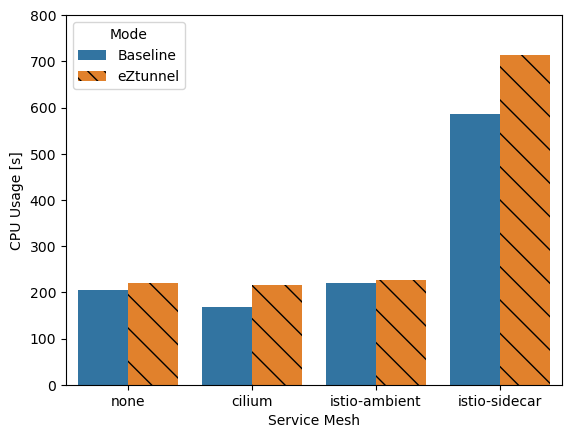

In [66]:
g = sns.barplot(data=cpu_seconds_usage[cpu_seconds_usage.workload.eq('redis')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='CPU Usage [s]',
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/redis-barplot-cpu-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [67]:
summary = redis.groupby(['service_mesh', 'optimization'])['ops_avg'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
)
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25            p50              avg  \
Service Mesh  Mode                                                        
none          Baseline            47902          48005          48248.8   
              eZtunnel    69583 (45.3%)  70765 (47.4%)  70342.8 (45.8%)   
cilium        Baseline            69571          70428          70332.6   
              eZtunnel     70866 (1.9%)   71332 (1.3%)   71566.4 (1.8%)   
istio-ambient Baseline            48279          48314          48737.2   
              eZtunnel    67252 (39.3%)  67290 (39.3%)  67553.6 (38.6%)   
istio-sidecar Baseline            17450        17528.5          17542.5   
              eZtunnel  17072.8 (-2.2%)  17232 (-1.7%)  17305.2 (-1.4%)   

                                    p75  
Service Mesh  Mode                       
none          Baseline            48594  
              eZtunnel    71096 (46.3%)  
cilium        Baseline            70701  
              eZtunnel     71756 (1.5%)  
istio-ambient Baseline            48781  
              eZtunnel    67577 (38.5%)  
istio-sidecar Baseline            17621  
              eZtunnel  17464.5 (-0.9%)

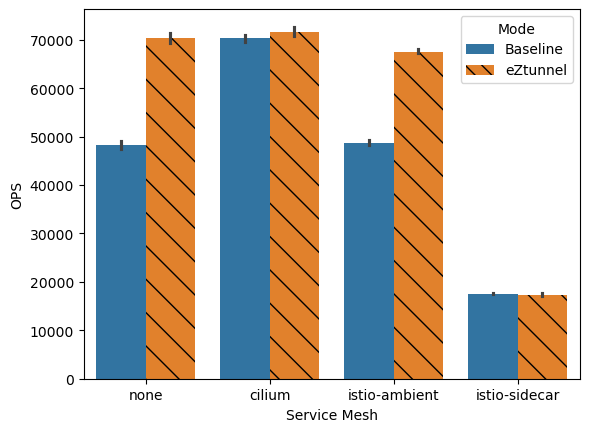

In [68]:
g = sns.barplot(data=redis, y='ops_avg', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='OPS',
    #yticklabels=[],
)

g.legend(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/redis-barplot-ops.svg', bbox_inches='tight', metadata={'Date': None})

In [69]:
summary = redis.groupby(['service_mesh', 'optimization'])['throughput_avg'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'b', 'MB'))
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25          p50          avg          p75
Service Mesh  Mode                                                        
none          Baseline          2.1          2.1          2.1          2.1
              eZtunnel  3.0 (45.5%)  3.1 (47.2%)  3.1 (45.8%)  3.1 (46.8%)
cilium        Baseline          3.0          3.1          3.1          3.1
              eZtunnel   3.1 (2.1%)   3.1 (1.0%)   3.1 (1.7%)   3.1 (1.4%)
istio-ambient Baseline          2.1          2.1          2.1          2.1
              eZtunnel  2.9 (39.5%)  2.9 (39.5%)  2.9 (38.8%)  2.9 (38.6%)
istio-sidecar Baseline          0.8          0.8          0.8          0.8
              eZtunnel  0.7 (-2.2%)  0.7 (-1.7%)  0.8 (-1.4%)  0.8 (-0.9%)

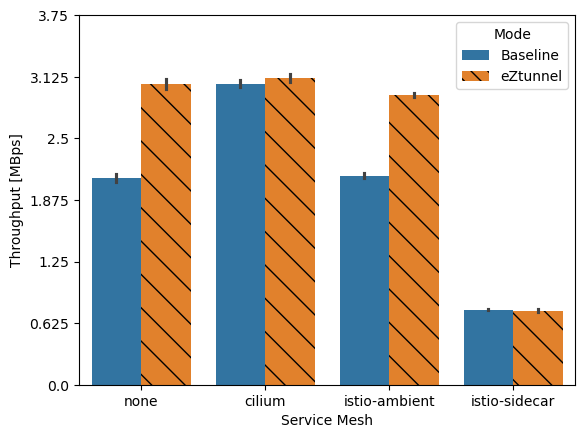

In [70]:
g = sns.barplot(data=redis, y='throughput_avg', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Throughput [MBps]',
    yticklabels=[format_data_size(tick, 'b', 'MB') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/redis-barplot-throughput.svg', bbox_inches='tight', metadata={'Date': None})

In [71]:
summary = redis.groupby(['service_mesh', 'optimization'])['latency_avg'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'ms'))
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25           p50           avg           p75
Service Mesh  Mode                                                            
none          Baseline           2.0           2.1           2.1           2.1
              eZtunnel  1.4 (-31.7%)  1.4 (-32.2%)  1.4 (-31.5%)  1.4 (-31.2%)
cilium        Baseline           1.4           1.4           1.4           1.4
              eZtunnel   1.4 (-1.4%)   1.4 (-1.4%)   1.4 (-1.6%)   1.4 (-1.4%)
istio-ambient Baseline           2.0           2.1           2.0           2.1
              eZtunnel  1.5 (-27.8%)  1.5 (-28.5%)  1.5 (-27.9%)  1.5 (-28.5%)
istio-sidecar Baseline           5.7           5.7           5.7           5.7
              eZtunnel    5.7 (0.9%)    5.8 (1.7%)    5.8 (1.4%)    5.8 (2.1%)

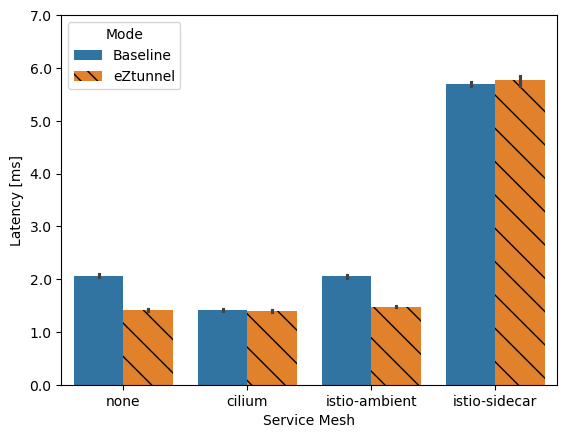

In [72]:
g = sns.barplot(data=redis, y='latency_avg', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Latency [ms]',
    yticklabels=[format_time(tick, 'ns', 'ms') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/redis-barplot-latency.svg', bbox_inches='tight', metadata={'Date': None})

In [73]:
summary = redis.groupby(['service_mesh', 'optimization'])['took'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 's'))
summary = summary_value(summary, index=1)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25          p50            avg        p75
Service Mesh  Mode                                                        
none          Baseline           20           20           20.2         20
              eZtunnel    14 (-30%)    14 (-30%)  13.8 (-31.7%)  14 (-30%)
cilium        Baseline           14           14           13.8         14
              eZtunnel   13 (-7.1%)      14 (0%)   13.6 (-1.4%)    14 (0%)
istio-ambient Baseline           20           20           19.8         20
              eZtunnel    14 (-30%)    14 (-30%)    14 (-29.3%)  14 (-30%)
istio-sidecar Baseline           56         56.5           56.5         57
              eZtunnel  56.8 (1.3%)  57.5 (1.8%)    57.2 (1.3%)  58 (1.8%)

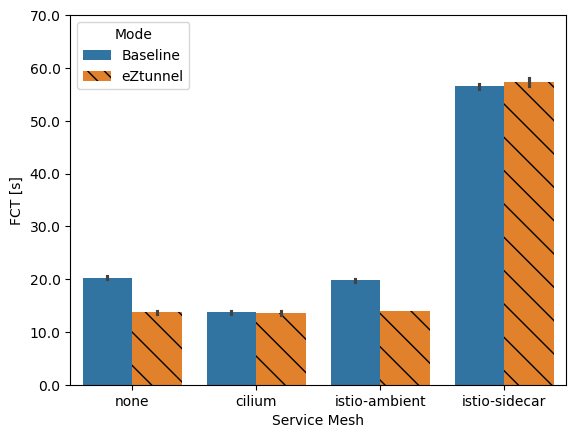

In [74]:
g = sns.barplot(data=redis, y='took', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='FCT [s]',
    yticklabels=[format_time(tick, 'ns', 's') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': GIVEN_NAME})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('graphs/redis-barplot-fct.svg', bbox_inches='tight', metadata={'Date': None})

In [75]:
redis_hist.head()

,cni,iteration,optimization,service_mesh,workload,latency,percentile,total_count,total_count_diff
0,calico,3,disabled,istio-ambient,redis,4.7e-02,0.0e+00,2,2
1,calico,3,disabled,istio-ambient,redis,1.2e+00,5.0e-02,51144,51142
2,calico,3,disabled,istio-ambient,redis,1.4e+00,1.0e-01,100043,48899
3,calico,3,disabled,istio-ambient,redis,1.4e+00,1.5e-01,150213,50170
4,calico,3,disabled,istio-ambient,redis,1.5e+00,2.0e-01,205650,55437


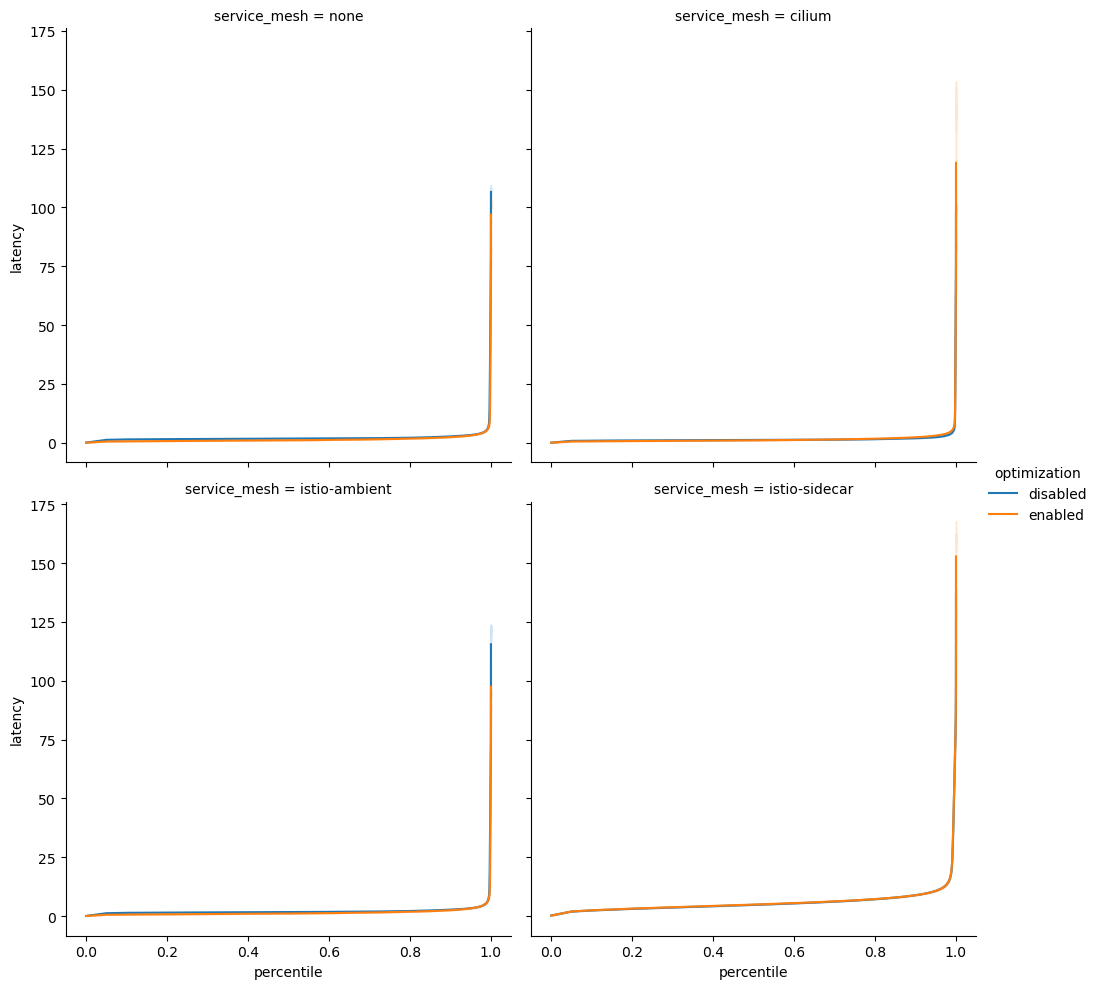

In [76]:
g = sns.relplot(
    data=redis_hist, x='percentile', y='latency',
    col='service_mesh', col_wrap=2, col_order=service_mesh_order, hue='optimization',
    kind='line'
)

#for ax in g.axes:
#    service_mesh = ax.get_title().replace('service_mesh = ', '')
#    ax.set_title(f'Service Mesh = {service_mesh}')
#    p99 = hgrm_quantile(redis_hist[redis_hist.service_mesh.eq(service_mesh)], .99).latency
#    ax.axvline(.99, linestyle='--', color='r', label=f'{service_mesh} = {p99}')

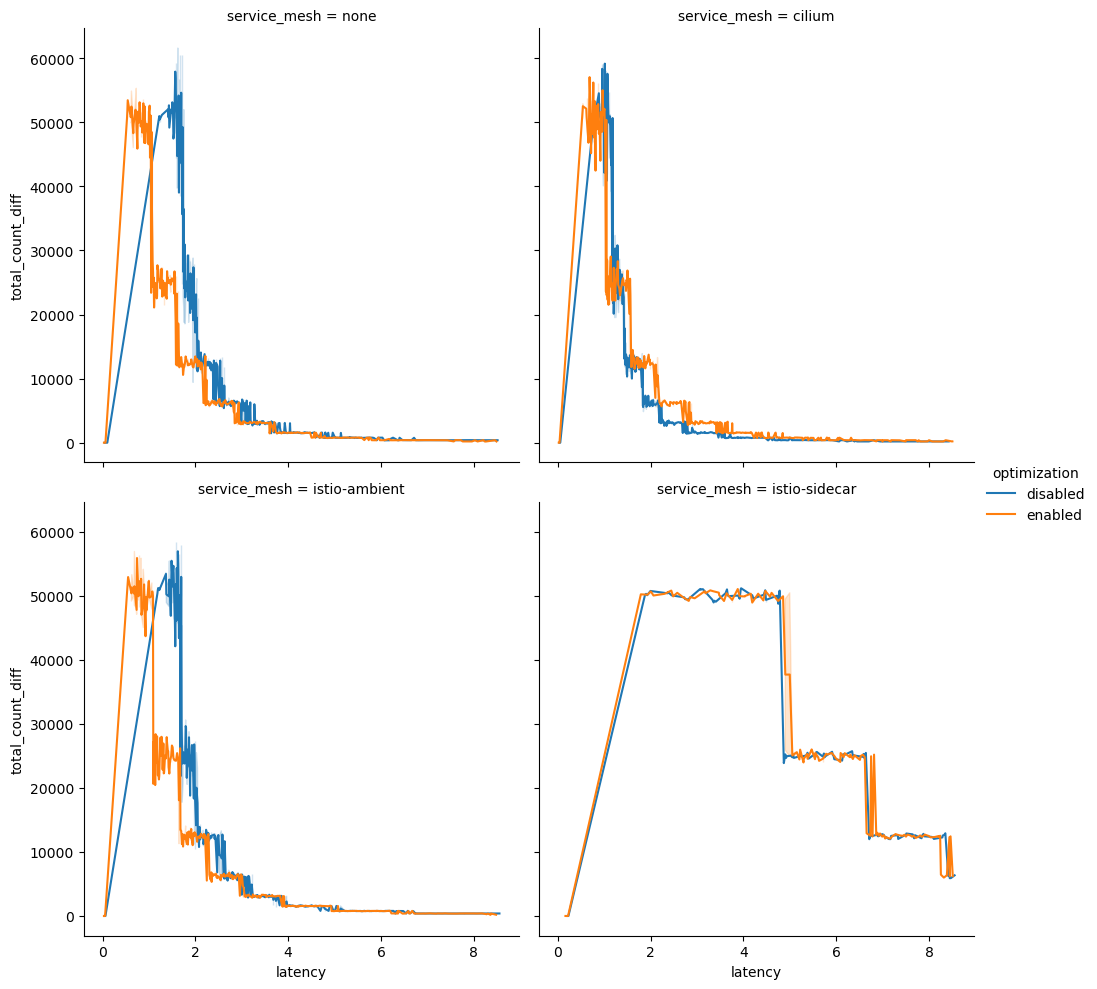

In [77]:
sns.relplot(
    data=redis_hist[redis_hist.latency.le(hgrm_quantile(redis_hist, .995).latency)], y='total_count_diff', x='latency',
    col='service_mesh', col_wrap=2, col_order=service_mesh_order, hue='optimization',
    kind='line'
)